Author: **Stefano Petrocchi**


## Dependencies and Variables:

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import datetime
import os
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tensorflow.python.util import deprecation
from tensorflow.keras.utils import plot_model
import pickle


deprecation._PRINT_DEPRECATION_WARNINGS = False

disable_eager_execution() #To execute the gradient

BASE_PATH = "drive/MyDrive/Petrocchi"
MODELS_PATH = BASE_PATH + "/models"
DATA_PATH = BASE_PATH + "/data/"
CHECKPOINT_PATH = BASE_PATH + "/checkpoints"
HISTORY_PATH = BASE_PATH + "/history"

labels_dict = {
  "0": "BASELINE",
  "1": "MASS BENIGN",
  "2": "MASS MALIGNANT",
  "3": "CALCIFICATION BENIGN",
  "4": "CALCIFICATION MALIGNANT"
}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q pyyaml h5py

In [4]:
!pip install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=99f4c03f3cbc89b0f67a3f56eecb1de161117b8f4fd70bdbd29429434c9ea911
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [5]:
# Get util functions
import import_ipynb
import drive.MyDrive.Petrocchi.util.preprocessing as preprocessing
import drive.MyDrive.Petrocchi.util.models as my_models
import drive.MyDrive.Petrocchi.util.visualization as visual
import drive.MyDrive.Petrocchi.util.SVM as svm

importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/preprocessing.ipynb
"load_images_and_lables" function loaded
"preprocess_normalize_images" function loaded
"deprocess_image_to_RGB" function loaded
"deprocess_image" function loaded
"datagen" class loaded
"binary_subdivision" function loaded
importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/models.ipynb
"tiny_net" CNN loaded
"mammo_net" CNN loaded
importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/visualization.ipynb
"plot_history" function loaded
"plot_roc_curve" function loaded
"plot_confusion_matrix" function loaded
"generate_pattern" function loaded
"display_filters_patterns" function loaded
"display_features_maps" function loaded
"generate_pattern_RGB" function loaded
"display_filters_patterns" function loaded
importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/SVM.ipynb
"create_feature_extractor" function loaded
"extract_features" function loaded
"train_s

## Data Loading:

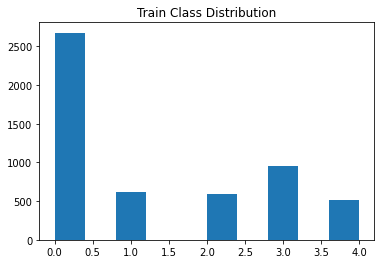

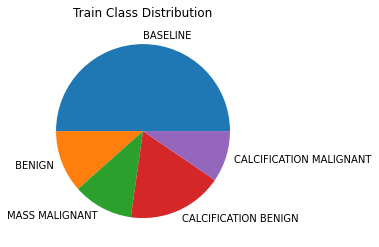

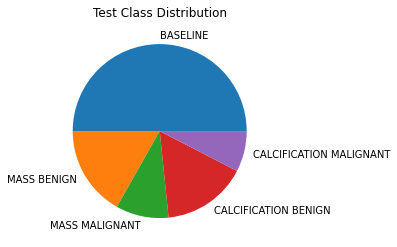

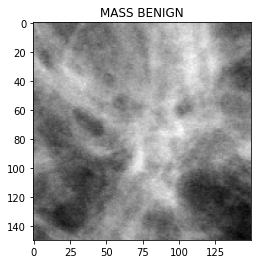

In [11]:
train_images, train_labels= preprocessing.load_images_and_lables(DATA_PATH + 'train_tensor.npy', DATA_PATH + 'train_labels.npy')
test_images, test_labels= preprocessing.load_images_and_lables(DATA_PATH + 'public_test_tensor.npy', DATA_PATH + 'public_test_labels.npy')

# Class Distribution
plt.hist(train_labels)
plt.title("Train Class Distribution")
plt.show()

unique, counts = np.unique(train_labels, return_counts=True)
plt.pie(counts, labels = ["BASELINE"," BENIGN","MASS MALIGNANT","CALCIFICATION BENIGN","CALCIFICATION MALIGNANT"])
plt.title('Train Class Distribution')
plt.show()

unique, counts = np.unique(test_labels, return_counts=True)
plt.pie(counts, labels = ["BASELINE","MASS BENIGN","MASS MALIGNANT","CALCIFICATION BENIGN","CALCIFICATION MALIGNANT"])
plt.title('Test Class Distribution')
plt.show()

# Plot an example
img_index = 5
plt.imshow(train_images[img_index,:,:],cmap = 'gray')
plt.title(labels_dict[str(train_labels[img_index])])
plt.show()

## General Data Preprocessing:

Normalize and convert to RGB:

In [12]:
# I also need to convert back to numpy array using eval()
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.Session()
with sess.as_default():
  print(train_images.shape)
  pp_train_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(preprocessing.preprocess_normalize_images(train_images, train_images.mean(), train_images.std()))).eval()
  print(pp_train_images.shape)

  print(test_images.shape)
  pp_test_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(preprocessing.preprocess_normalize_images(test_images, train_images.mean(), train_images.std()))).eval()
  print(pp_test_images.shape)

(5352, 150, 150)
(5352, 150, 150, 3)
(672, 150, 150)
(672, 150, 150, 3)


Abnormalities-Baselines subdivision

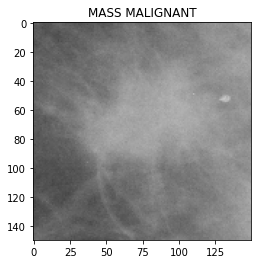

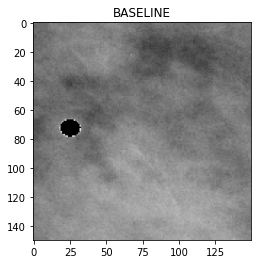

In [13]:
# For reference
idx = 1
plt.imshow(preprocessing.deprocess_image_to_RGB(pp_train_images[idx]))
plt.title(labels_dict[str(train_labels[idx])])
plt.show()
plt.imshow(preprocessing.deprocess_image_to_RGB(pp_train_images[idx-1]))
plt.title(labels_dict[str(train_labels[idx-1])])
plt.show()

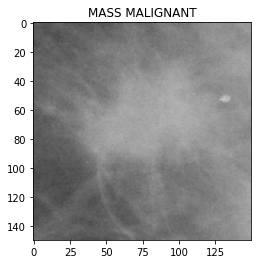

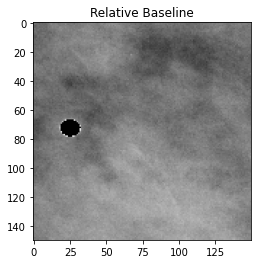

In [14]:
#Train
train_abnormalities = pp_train_images[1::2]
train_abnormalities_labels = train_labels[1::2]
train_baselines = pp_train_images[::2]

#Test
test_abnormalities = pp_test_images[1::2]
test_abnormalities_labels = test_labels[1::2]
test_baselines = pp_test_images[::2]

# Confirms that subdivision is good
idx = 0
plt.imshow(preprocessing.deprocess_image_to_RGB(train_abnormalities[idx]))
plt.title(labels_dict[str(train_abnormalities_labels[idx])])
plt.show()
plt.imshow(preprocessing.deprocess_image_to_RGB(train_baselines[idx]))
plt.title("Relative Baseline")
plt.show()

Test Augmentation:

(1, 150, 150, 3)


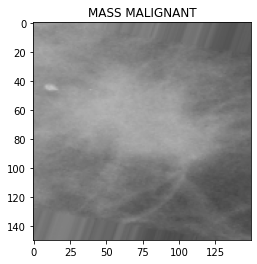

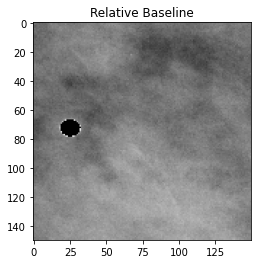

In [15]:
# Test: show random augmented image
for batch in preprocessing.datagen.flow([train_abnormalities[0:1],train_baselines[0:1]], train_abnormalities_labels[0:1], batch_size=1):
    plt.title(labels_dict[str(batch[1][0])])
    print(batch[0][0].shape)
    plt.imshow(preprocessing.deprocess_image_to_RGB(batch[0][0][0][:,:,:]))
    plt.show()
    plt.imshow(preprocessing.deprocess_image_to_RGB(batch[0][1][0][:,:,:]))
    plt.title("Relative Baseline")
    plt.show()
    break

Binary subdivision:

Masses and Calcifications
(2676, 150, 150, 3)
(2676,)
(336, 150, 150, 3)
(336,)


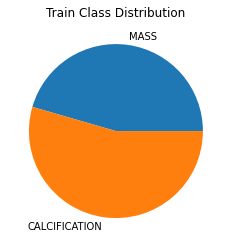

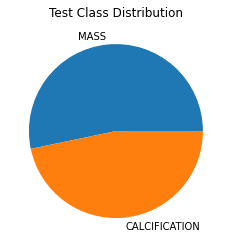

In [16]:
# 0: MASS, 1: CALCIFICATION
mc_train_images, mc_train_labels, mc_test_images, mc_test_labels = preprocessing.binary_subdivision( 
    [1,2], [3,4], train_abnormalities, train_abnormalities_labels, test_abnormalities, test_abnormalities_labels)  

print("Masses and Calcifications")
print(mc_train_images.shape)
print(mc_train_labels.shape)
print(mc_test_images.shape)
print(mc_test_labels.shape)

# Class Distribution
unique, counts = np.unique(mc_train_labels, return_counts=True)
plt.pie(counts, labels = ["MASS","CALCIFICATION"])
plt.title('Train Class Distribution')
plt.show()

unique, counts = np.unique(mc_test_labels, return_counts=True)
plt.pie(counts, labels = ["MASS","CALCIFICATION"])
plt.title('Test Class Distribution')
plt.show()


# Siamese Mass VS Calcification Classifiers

### Split:

(2140, 150, 150, 3)
(2140,)
(536, 150, 150, 3)
(536,)
(2140, 150, 150, 3)
(536, 150, 150, 3)


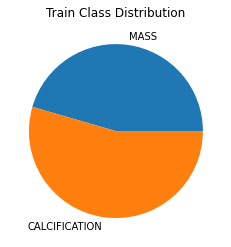

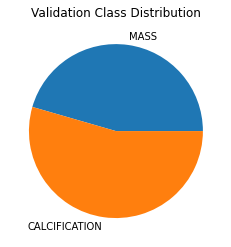

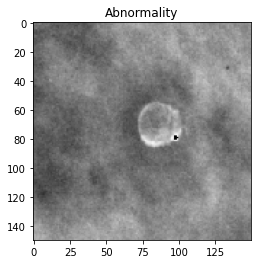

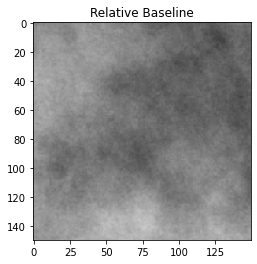

In [17]:
mc_train_images, mc_train_labels, mc_val_images, mc_val_labels, mc_val_baselines, mc_train_baselines = preprocessing.split_train_validation_baseline(mc_train_images, mc_train_labels, 0.2, train_baselines)

print(mc_train_images.shape)
print(mc_train_labels.shape)
print(mc_val_images.shape)
print(mc_val_labels.shape)
print(mc_train_baselines.shape)
print(mc_val_baselines.shape)

# Class Distribution
unique, counts = np.unique(mc_train_labels, return_counts=True)
plt.pie(counts, labels = ["MASS","CALCIFICATION"])
plt.title('Train Class Distribution')
plt.show()

unique, counts = np.unique(mc_val_labels, return_counts=True)
plt.pie(counts, labels = ["MASS","CALCIFICATION"])
plt.title('Validation Class Distribution')
plt.show()

idx = 22
plt.imshow(preprocessing.deprocess_image_to_RGB(mc_val_images[idx]))
plt.title("Abnormality")
plt.show()
plt.imshow(preprocessing.deprocess_image_to_RGB(mc_val_baselines[idx]))
plt.title("Relative Baseline")
plt.show()

###General Parameters for training:

In [18]:
K.clear_session()

In [19]:
# Training parameters that are good for all models

# From ISMMS paper 32
# From Girona & Manchester paper 128
BATCH_SIZE = 107 # to have even batches 
STEPS_PER_EPOCH = len(mc_train_images) // BATCH_SIZE # 20
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.00001) # From Ecuador/Brazil paper
LOSS = 'binary_crossentropy'

# Large values ensures to not lose better weights 
MAX_EPOCHS = 1000 
PATIENCE = 50 

# Automatically restore best weights after early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = PATIENCE, restore_best_weights = True)

### Siamese Features Difference:

Frozen layers:
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
Model: "siamese_mass_calcification_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
VGG16_TL_mass_calcification (Se (None, 8192)         14714688    left_input[0][0]                 
                                                                 right_input[0][0]                
________________________________________________________

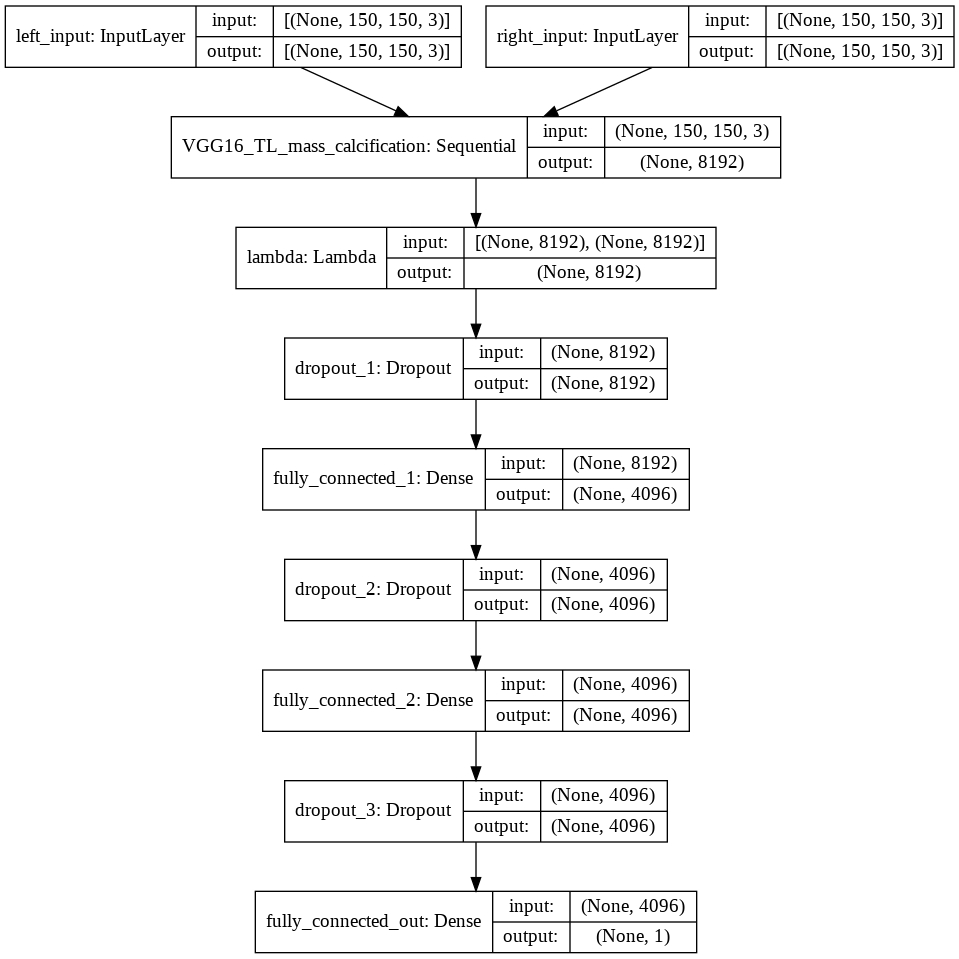

In [20]:
from tensorflow.keras.applications import VGG16

TOP_K_FROZEN_LAYERS = 8
input_shape=(150, 150, 3)

# Define the tensors for the two input images
left_input = keras.Input(input_shape, name = "left_input")
right_input = keras.Input(input_shape, name = "right_input")

# Convolutional Neural Network
VGG16_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)
VGG16_base.trainable = False

print("Frozen layers:")
for idx in range(TOP_K_FROZEN_LAYERS):
  print(VGG16_base.layers[idx].name)
  VGG16_base.layers[idx].trainable = False

VGG16_mc = models.Sequential(name = "VGG16_TL_mass_calcification")
VGG16_mc.add(VGG16_base)
VGG16_mc.add(layers.Flatten(name = "flatten"))

# Generate the encodings (feature vectors) for the two images
encoded_l = VGG16_mc(left_input)
encoded_r = VGG16_mc(right_input)

# Add a customized layer to compute the absolute difference between the encodings
L1_layer = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]), name = "lambda")
L1_distance = L1_layer([encoded_l, encoded_r])

# Add a dense layer with a sigmoid unit to generate the similarity score
drop1 = layers.Dropout(0.2, name = "dropout_1")(L1_distance)
fc1 = layers.Dense(4096, activation='relu', name = "fully_connected_1")(drop1)
drop2 = layers.Dropout(0.2, name = "dropout_2")(fc1)
fc2 = layers.Dense(4096, activation='relu', name = "fully_connected_2")(drop2)
drop3 = layers.Dropout(0.1, name = "dropout_3")(fc2)
prediction = layers.Dense(1, activation='sigmoid', name = "fully_connected_out")(drop3)

# Connect the inputs with the outputs
siamese_mc_difference = Model(inputs=[left_input,right_input],outputs=prediction, name="siamese_mass_calcification_net")

siamese_mc_difference.summary()


siamese_mc_difference.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/siamese_mc_difference/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

plot_model(siamese_mc_difference, show_shapes=True)

Training:

In [ ]:
siamese_mc_difference_history = siamese_mc_difference.fit(preprocessing.datagen.flow([mc_train_images,mc_train_baselines], mc_train_labels, batch_size=BATCH_SIZE),
                       steps_per_epoch=STEPS_PER_EPOCH,  
                       epochs=MAX_EPOCHS, 
                       validation_data = ([mc_val_images,mc_val_baselines], mc_val_labels),
                       callbacks=[es_callback])#, cp_callback])

Epoch 1/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6641 - accuracy: 0.5636

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20/20 [==============================] - 26s 688ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6641 - accuracy: 0.5636 - val_loss: 0.6040 - val_accuracy: 0.7239
Epoch 2/1000
20/20 [==============================] - 15s 767ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.5972 - accuracy: 0.7196 - val_loss: 0.5458 - val_accuracy: 0.7369
Epoch 3/1000
20/20 [==============================] - 16s 791ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.5519 - accuracy: 0.7645 - val_loss: 0.4905 - val_accuracy: 0.7519
Epoch 4/1000
20/20 [==============================] - 16s 797ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.5063 - accuracy: 0.8051 - val_loss: 0.4556 - val_accuracy: 0.7743
Epoch 5/1000
20/20 [==============================] - 16s 801ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.4758 - accuracy: 0.8075 - val_loss: 0.4295 - val_accuracy: 0.7799
Epoch 6/1000
20/20 [==============================] - 16s 803ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.4397 - accu

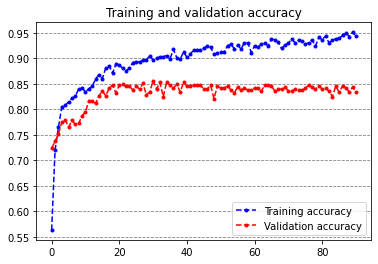

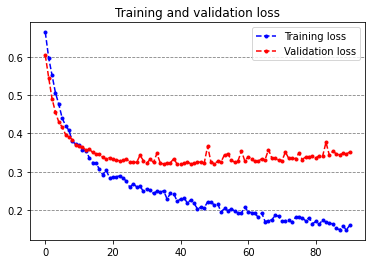

In [ ]:
# Save and load history
with open(HISTORY_PATH + '/siamese_mc_difference_history', 'wb') as file_pi:
        pickle.dump(siamese_mc_difference_history.history, file_pi)

siamese_mc_difference_history = pickle.load(open(HISTORY_PATH + '/siamese_mc_difference_history', "rb"))

visual.plot_history(siamese_mc_difference_history)

In [ ]:
train_loss, train_acc = siamese_mc_difference.evaluate([mc_train_images,mc_train_baselines], mc_train_labels)
print(f"Accuracy on train set: {round(train_acc*100, 2)}% \nLoss on train set: {round(train_loss,4)}")
val_loss, val_acc = siamese_mc_difference.evaluate([mc_val_images,mc_val_baselines], mc_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
test_loss, test_acc = siamese_mc_difference.evaluate([mc_test_images,test_baselines], mc_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

Accuracy on train set: 91.87% 
Loss on train set: 0.2035
Accuracy on validation set: 84.51% 
Loss on validation set: 0.3712
Accuracy on test set: 82.44% 
Loss on test set: 0.4357


Load best weights and save:

In [ ]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/siamese_mc_difference/")
#siamese_mc_difference.load_weights(best)

In [ ]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
siamese_mc_difference.save(os.path.join(MODELS_PATH,'siamese_mc_difference.h5'))

### Siamese Features Concatenated:

In [ ]:
from tensorflow.keras.applications import VGG16

TOP_K_FROZEN_LAYERS = 8
input_shape=(150, 150, 3)

# Define the tensors for the two input images
left_input = keras.Input(input_shape, name="left_input")
right_input = keras.Input(input_shape, name="right_input")

# Convolutional Neural Network
VGG16_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)
VGG16_base.trainable = False

print("Frozen layers:")
for idx in range(TOP_K_FROZEN_LAYERS):
  print(VGG16_base.layers[idx].name)
  VGG16_base.layers[idx].trainable = False

VGG16_mc = models.Sequential(name = "VGG16_TL_mass_calcification")
VGG16_mc.add(VGG16_base)
VGG16_mc.add(layers.Flatten(name = "flatten"))

# Generate the encodings (feature vectors) for the two images
encoded_l = VGG16_mc(left_input)
encoded_r = VGG16_mc(right_input)

# Concatenates the layers 
juxtapose_layer = layers.Concatenate()([encoded_l, encoded_r])

# Add a dense layer with a sigmoid unit to generate the similarity score
drop1 = layers.Dropout(0.2, name = "dropout_1")(juxtapose_layer)
fc1 = layers.Dense(4096, activation='relu', name = "fully_connected_1")(drop1)
drop2 = layers.Dropout(0.2, name = "dropout_2")(fc1)
fc2 = layers.Dense(4096, activation='relu', name = "fully_connected_2")(drop2)
drop3 = layers.Dropout(0.1, name = "dropout_3")(fc2)
prediction = layers.Dense(1, activation='sigmoid', name = "fully_connected_out")(drop3)

# Connect the inputs with the outputs
siamese_mc_concat = Model(inputs=[left_input,right_input],outputs=prediction, name="siamese_mass_calcification_net")

siamese_mc_concat.summary()


siamese_mc_concat.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/siamese_mc_concat/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

58892288/58889256 [==============================] - 0s 0us/step
Frozen layers:
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
Model: "siamese_mass_calcification_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
VGG16_TL_mass_calcification (Se (None, 8192)         14714688    left_input[0][0]                 
                                                                 right_input[0][0]        

Training:

In [ ]:
siamese_mc_concat_history = siamese_mc_concat.fit(preprocessing.datagen.flow([mc_train_images,mc_train_baselines], mc_train_labels, batch_size=BATCH_SIZE),
                       steps_per_epoch=STEPS_PER_EPOCH,  
                       epochs=MAX_EPOCHS, 
                       validation_data = ([mc_val_images,mc_val_baselines], mc_val_labels),
                       callbacks=[es_callback])#, cp_callback])

Epoch 1/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6334 - accuracy: 0.6332

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20/20 [==============================] - 24s 566ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6334 - accuracy: 0.6332 - val_loss: 0.4919 - val_accuracy: 0.8209
Epoch 2/1000
20/20 [==============================] - 13s 662ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.5227 - accuracy: 0.7617 - val_loss: 0.4607 - val_accuracy: 0.7593
Epoch 3/1000
20/20 [==============================] - 13s 682ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.4373 - accuracy: 0.8210 - val_loss: 0.3613 - val_accuracy: 0.8190
Epoch 4/1000
20/20 [==============================] - 13s 676ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.4008 - accuracy: 0.8290 - val_loss: 0.3730 - val_accuracy: 0.8004
Epoch 5/1000
20/20 [==============================] - 14s 740ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.3692 - accuracy: 0.8458 - val_loss: 0.3065 - val_accuracy: 0.8377
Epoch 6/1000
20/20 [==============================] - 13s 686ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.3382 - accu

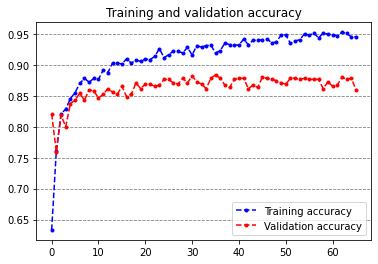

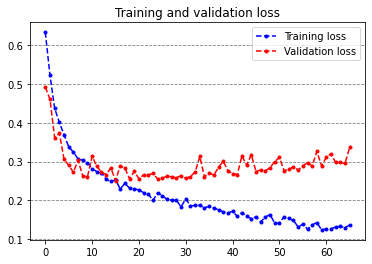

In [ ]:
# Save and load history
with open(HISTORY_PATH + '/siamese_mc_concat_history', 'wb') as file_pi:
        pickle.dump(siamese_mc_concat_history.history, file_pi)

siamese_mc_concat_history = pickle.load(open(HISTORY_PATH + '/siamese_mc_concat_history', "rb"))

visual.plot_history(siamese_mc_concat_history)

In [ ]:
train_loss, train_acc = siamese_mc_concat.evaluate([mc_train_images,mc_train_baselines], mc_train_labels)
print(f"Accuracy on train set: {round(train_acc*100, 2)}% \nLoss on train set: {round(train_loss,4)}")
val_loss, val_acc = siamese_mc_concat.evaluate([mc_val_images,mc_val_baselines], mc_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
test_loss, test_acc = siamese_mc_concat.evaluate([mc_test_images,test_baselines], mc_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

Accuracy on train set: 91.59% 
Loss on train set: 0.2078
Accuracy on validation set: 86.57% 
Loss on validation set: 0.2918
Accuracy on test set: 86.01% 
Loss on test set: 0.3053


Load best weights and save:

In [ ]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/siamese_mc_concat/")
#siamese_mc_concat.load_weights(best)

In [ ]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
siamese_mc_concat.save(os.path.join(MODELS_PATH,'siamese_mc_concat.h5'))

# Compare Results

##Scoring:

Siamese Difference
Accuracy on test set: 82.44% 
Loss on test set: 0.4357


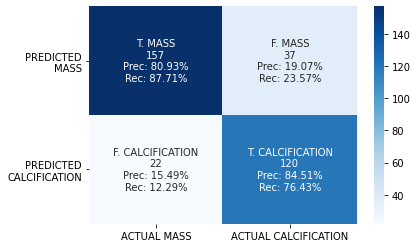

Siamese Concatenation
Accuracy on test set: 86.31% 
Loss on test set: 0.3014


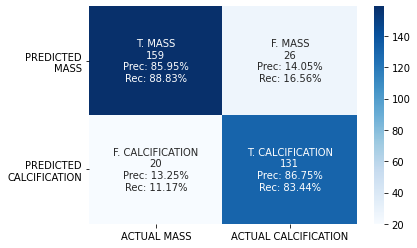

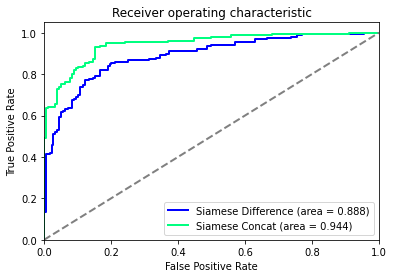

In [ ]:
# Siamese Difference
test_loss, test_acc = siamese_mc_difference.evaluate([mc_test_images,test_baselines], mc_test_labels)
print("Siamese Difference")
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

siamese_mc_difference_test_predictions = siamese_mc_difference.predict([mc_test_images,test_baselines])
binary_siamese_mc_difference_test_predictions = siamese_mc_difference_test_predictions.round()
visual.plot_confusion_matrix(mc_test_labels, binary_siamese_mc_difference_test_predictions, ["MASS", "CALCIFICATION"])

# Siamese Concatenation
test_loss, test_acc = siamese_mc_concat.evaluate([mc_test_images,test_baselines], mc_test_labels)
print("Siamese Concatenation")
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

siamese_mc_concat_test_predictions = siamese_mc_concat.predict([mc_test_images,test_baselines])
binary_siamese_mc_concat_test_predictions = siamese_mc_concat_test_predictions.round()
visual.plot_confusion_matrix(mc_test_labels, binary_siamese_mc_concat_test_predictions, ["MASS", "CALCIFICATION"])

models_predictions = [siamese_mc_difference_test_predictions,
                      siamese_mc_concat_test_predictions]

# ROC
visual.plot_roc_curve(mc_test_labels, models_predictions, ["Siamese Difference", "Siamese Concat"])


Author: **Stefano Petrocchi**
